In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

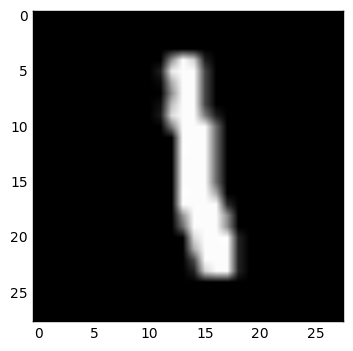

In [4]:
plt.imshow(X_train[6], cmap='gray')
plt.show()

In [5]:
input_dim = 784
n_l1 = 500
n_l2 = 200
z_dim = 2
batch_size = 1024

lr = 1e-3

In [6]:
tf.reset_default_graph()

In [7]:
def dense(x, n1, n2, name):
    with tf.variable_scope(name, reuse=None):
        W = tf.get_variable("weights", shape=[n1,n2],
                           initializer = tf.random_normal_initializer(mean=0., stddev=0.01))
        b = tf.get_variable("bias", shape=[n2], initializer=tf.constant_initializer(0.))
        out = tf.matmul(x, W) + b
        return out

In [8]:
def encoder(x):
    with tf.name_scope('Encoder'):
        e_dense_1 = tf.nn.relu(dense(x, input_dim, n_l1, 'e_dense_1'))
        e_dense_2 = tf.nn.relu(dense(e_dense_1, n_l1, n_l2, 'e_dense_2'))
        latent_var = dense(e_dense_2, n_l2, z_dim, 'e_latent_var')
        return latent_var        

In [9]:
def decoder(x):
    with tf.name_scope('Decoder'):
        d_dense_1 = tf.nn.relu(dense(x, z_dim, n_l2, 'd_dense_1'))
        d_dense_2 = tf.nn.relu(dense(d_dense_1, n_l2, n_l1, 'd_dense_2'))
        output = tf.nn.sigmoid(dense(d_dense_2, n_l1, input_dim, 'd_out'))
        return output

In [10]:
def discriminator(x, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Discriminator'):
        dc_den1 = tf.nn.relu(dense(x, z_dim, n_l1, name='dc_den1'))
        dc_den2 = tf.nn.relu(dense(dc_den1, n_l1, n_l2, name='dc_den2'))
        output = dense(dc_den2, n_l2, 1, name='dc_output')
        return output

In [19]:
all_var = tf.trainable_variables()
dc_var = [var for var in all_var if 'dc_' in var.name]
en_var = [var for var in all_var if 'e_' in var.name]

In [12]:
x_input = tf.placeholder(dtype = tf.float32, shape = [None, input_dim])
x_target = tf.placeholder(dtype=tf.float32, shape = [None, input_dim])
encoder_output = encoder(x_input)
decoder_output = decoder(encoder_output)

In [13]:
autoencoder_loss = tf.reduce_mean(tf.square(x_target - decoder_output))
train_autoencoder = tf.train.AdamOptimizer(learning_rate=lr).minimize(autoencoder_loss)

In [14]:
real_distribution = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='Real_dist')

In [15]:
with tf.variable_scope(tf.get_variable_scope()):
    d_real = discriminator(real_distribution)
    d_fake = discriminator(encoder_output, reuse=True)

In [16]:
dc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_real), logits=d_real))
dc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake))
dc_loss = dc_loss_real + dc_loss_fake

In [17]:
generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake), logits=d_fake))

In [20]:
train_dc = tf.train.AdamOptimizer(learning_rate=lr).minimize(dc_loss, var_list=dc_var)
train_gen = tf.train.AdamOptimizer(learning_rate=lr).minimize(generator_loss, var_list=en_var)

In [21]:
sess = tf.Session()

In [22]:
sess.run(tf.global_variables_initializer())
for i in tqdm(range(50)):
    permutations = list(np.random.permutation(60000))
    num_batches = int(np.floor((60000-1)/batch_size))
    for k in range(0, num_batches+1):
        z_real_sample = np.random.randn(batch_size, z_dim)*5
        indexes = permutations[k*batch_size:(k+1)*batch_size]
        mb_X= np.vstack([X_train[i].reshape(-1,)/255 for i in indexes])
        sess.run(train_autoencoder, feed_dict = {x_input:mb_X, x_target : mb_X})
        sess.run(train_dc, feed_dict={x_input: mb_X, real_distribution:z_real_sample})
        sess.run(train_gen, feed_dict = {x_input:mb_X, x_target : mb_X})

100%|██████████| 50/50 [13:29<00:00, 16.18s/it]


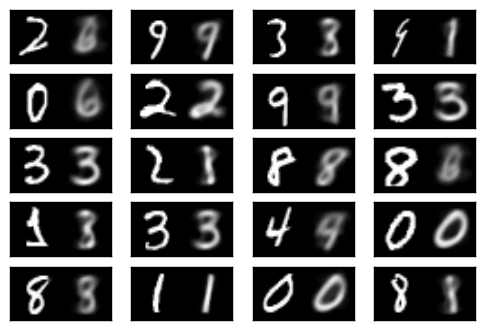

In [23]:
_, ax = plt.subplots(5, 4)
indexes = np.random.choice(60000,20,replace=False)
mb_X= np.vstack([X_train[i].reshape(-1,)/255 for i in indexes])
gen_output = sess.run(decoder_output, feed_dict = {x_input:mb_X})
for i in range(20):
    img = np.hstack((X_train[indexes[i]],gen_output[i].reshape(28,28)*255))
    ax[i//4,i%4].imshow(img, cmap='gray')
    ax[i//4,i%4].set_xticks([])
    ax[i//4,i%4].set_yticks([])
    ax[i//4,i%4].set_aspect('auto')
plt.show()

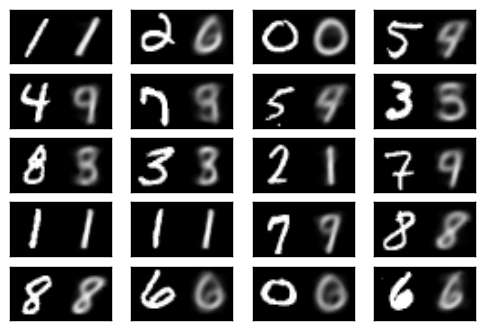

In [24]:
_, ax = plt.subplots(5, 4)
indexes = np.random.choice(10000,20,replace=False)
mb_X= np.vstack([X_test[i].reshape(-1,)/255 for i in indexes])
gen_output = sess.run(decoder_output, feed_dict = {x_input:mb_X})
for i in range(20):
    img = np.hstack((X_test[indexes[i]],gen_output[i].reshape(28,28)*255))
    ax[i//4,i%4].imshow(img, cmap='gray')
    ax[i//4,i%4].set_xticks([])
    ax[i//4,i%4].set_yticks([])
    ax[i//4,i%4].set_aspect('auto')
plt.show()

In [25]:
arr = np.arange(-10,10.1,2)
values = []
for i in range(121):
    values.append([arr[i%11],arr[i//11]])
values = np.array(values)

In [26]:
values.shape

(121, 2)

In [27]:
gen_numbers = sess.run(decoder_output, feed_dict={encoder_output: values})

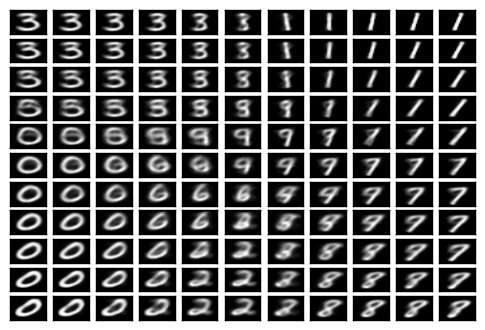

In [28]:
_, ax = plt.subplots(11, 11)
for i in range(121):
    ax[i//11,i%11].imshow(gen_numbers[i].reshape(28,28)*255, cmap='gray')
    ax[i//11,i%11].set_xticks([])
    ax[i//11,i%11].set_yticks([])
    ax[i//11,i%11].set_aspect('auto')
plt.show()    